In [2]:
import os
import cv2
import joblib
from scipy.cluster.vq import kmeans,vq
import numpy as np
from sklearn.metrics import confusion_matrix
from numpy.linalg import norm
import matplotlib.pyplot as plt

In [3]:
#Path of the dataset
path = "styles/"
#https://docs.python.org/3/library/pathlib.html
images_file = [path + x for x in os.listdir(path) if "png" in x]
print("number of images:",len(images_file))

number of images: 2184


In [4]:
images_file[0]

'style/0_0_001.png'

In [5]:
#Reading the training image and storing
image_all = []
for image in images_file:
    img = cv2.imread(image)
    # Convert the image data to arrays
    image_all.append(np.array(img))

In [6]:
#https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
def extractor():
    # Feature extractor that we use sift
    sift = cv2.SIFT_create()
    global all_keypoints,all_descriptors
    all_keypoints = []
    all_descriptors = []
    for img in image_all:
        # Extract all the keypoints and descriptors
        kp, des = sift.detectAndCompute(img, None)
        # Save all the keypoinst and descriptors in a list
        all_keypoints.append(kp)
        all_descriptors.append(des)
extractor()

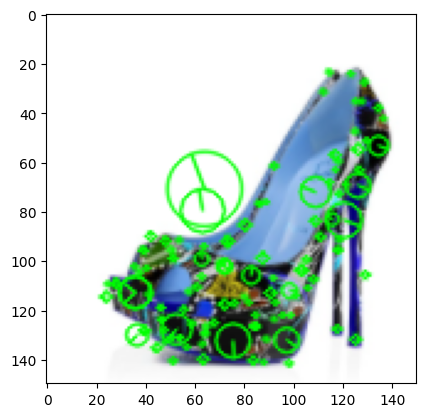

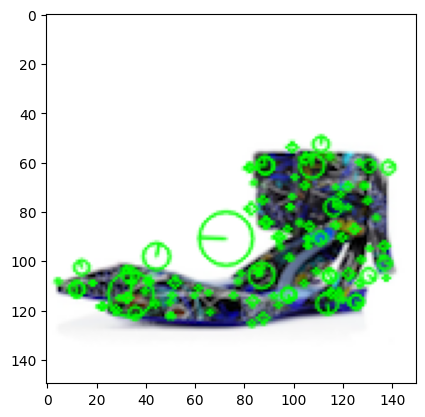

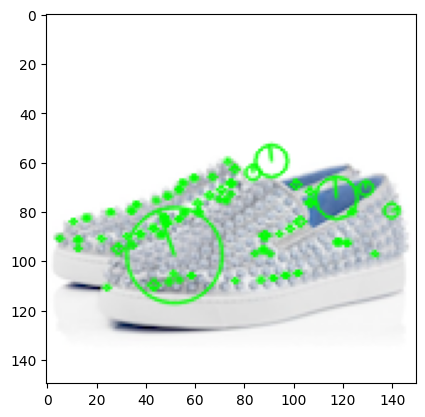

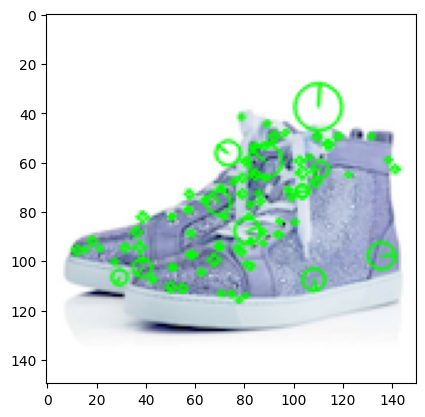

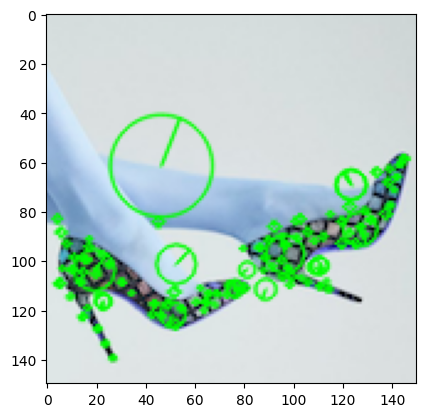

In [7]:
def view_extracted_features():
    extracted_images = []
    n= 5
    for i in range(n):
        #https://docs.opencv.org/4.x/da/df5/tutorial_py_sift_intro.html
        #Mark a circle on the extracted areas in an image
        extracted_images.append(cv2.drawKeypoints(image_all[i], all_keypoints[i], 0, (0,255,0),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
        #Show the extracted areas
        plt.imshow(extracted_images[i])
        plt.show()
view_extracted_features()

In [8]:
#https://www.youtube.com/watch?v=PRceoMWcv1U&t=1621s
def compile_descriptors_float():
    global all_img_descriptors
    training_descriptors = []
    all_img_descriptors = []
    #Making random selection and converting to stack float32
    np.random.seed(0)
    descriptor_ids = np.random.randint(0, len(image_all)+1, 1500).tolist()
    for i in descriptor_ids:
        training_descriptors.append(np.array(all_descriptors[i]))
    for img_descriptors in training_descriptors:
        for descriptor in img_descriptors:
            all_img_descriptors.append(descriptor)
    all_img_descriptors = np.stack(all_img_descriptors)
compile_descriptors_float()

In [9]:
all_img_descriptors.shape

(154115, 128)

In [10]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.vq.kmeans.html
def kmeans_cluster():
    global k,code_book
    k = 100
    # K-means clustering for making a dictionary
    code_book, variance = kmeans(all_img_descriptors, k, 1)
    # Saving the dictionary to a file
    joblib.dump(code_book,"bvw_features.pkl", compress=3)

kmeans_cluster()

In [11]:
#https://github.com/ovysotska/in_simple_english/blob/master/bag_of_visual_words.ipynb
def load_code_book():
    # loading the dictionary
    #code_book = joblib.load("bvw_features.pkl")
    global images_vectors
    images_vectors = []
    for n in range(len(all_descriptors)-600):
        #vector quantization
        word, distance = vq(all_descriptors[n], code_book)
        img_vector = np.zeros(k)
        for w in word:
            img_vector[w] += 1
        images_vectors.append(img_vector)
    #Frequency vector
    images_vectors = np.stack(images_vectors)
load_code_book()  

In [13]:
#https://github.com/ovysotska/in_simple_english/blob/master/bag_of_visual_words.ipynb
def tf_id_weighting():
    global t_i_d
    #the number of images in dataset
    N = len(images_file)
    #compute number of image that contain the word 
    n_i = np.sum(images_vectors > 0, axis=0)
    #compute inverse document frequency
    i_d_f = np.log(N/ n_i)
    #compute termed frequency-inverse document frequency
    t_i_d = images_vectors * i_d_f

tf_id_weighting()

1000
similarity score :1.0


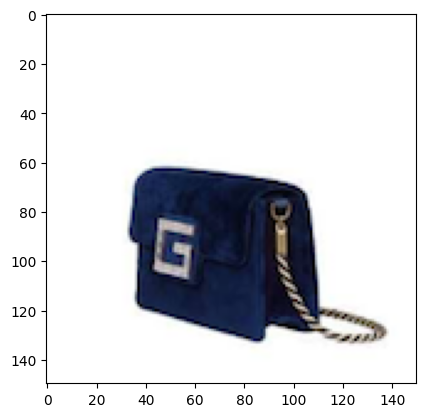

1442
similarity score :0.7298892


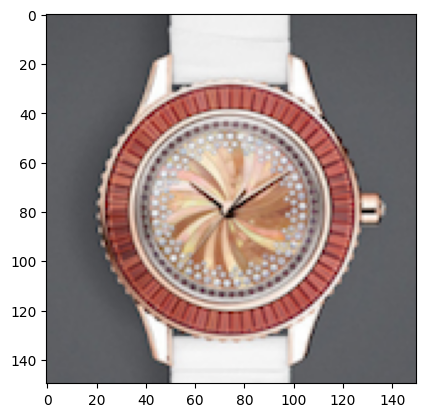

1411
similarity score :0.6800318


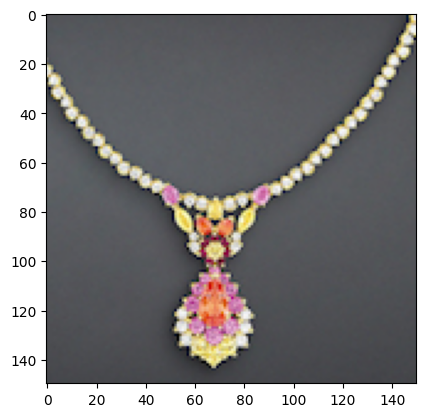

1396
similarity score :0.6632583


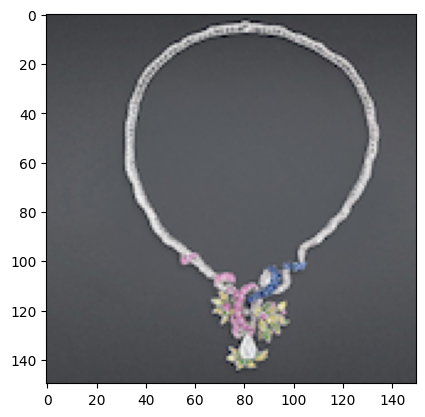

In [25]:
#https://github.com/ovysotska/in_simple_english/blob/master/bag_of_visual_words.ipynb
def recommended_products(image):
    recommended_styles = 4
    # Get the vector of the search image
    a = t_i_d[image]
    # set all of the vector of the images
    b = t_i_d
    c= norm(a) * norm(b, axis=1)
    #compute cosine-similarity
    cosine_similarity = np.dot(a, b.T)/c
    #Get the id's of images similar
    id = np.argsort(-cosine_similarity)[:recommended_styles]
    for i in id:
        print(i)
        #Print the similarity score
        print(f"similarity score :{round(cosine_similarity[i], 7)}")
        plt.imshow(cv2.cvtColor(image_all[i], cv2.COLOR_BGR2RGB))
        plt.show()
    
recommended_products(1000)